# This is a DMBDI explorer user template. DO NOT EDIT!

In order to use, copy the notebook through navigating in the navbar: File → Make a Copy. Make sure your copy of the notebook has a user-specific name, e.g. `DMBDI_explorer_adamkurkiewicz`. You can work in your copy without the fear of breaking anything (and even if you do break things, I'll fix it, so don't worry about it and do some
science!)

# First, we can load all the required imports

In [1]:
import os
from explorer import *
%matplotlib inline

# Next we load all the genecode genes.

In [2]:
genecode_genes = set(os.listdir("analysis/experiment_blood"))

In [3]:
len(genecode_genes)

19826

# As well as the relevant metadata, i.e. Modal Allele Length (MAL), Progenitor Allele Length (PAL) and Muscle Impairment Rating Scale (MIRS) 

In [4]:
blood_metadata, muscle_metadata = load_metadata("analysis/metadata.txt")

# We read in a previously identified list of genes implied in spliceopathy of DM1
Taken from [Nakamori et al.](https://doi.org/10.1002/ana.23992)

In [5]:
nakamori = load_genes(genecode_genes, "analysis/nakamori_genes.txt")

Loading analysis/nakamori_genes.txt. These genes appear more than once: ['DMD', 'LDB3', 'PHKA1']


In [6]:
len(nakamori)

38

In [7]:
print(nakamori)

{'FHOD1', 'VEGFA', 'TTN', 'KIF13A', 'GFPT1', 'CAMK2B', 'BIN1', 'ANK2', 'OPA1', 'COPZ2', 'CAPN3', 'PDLIM3', 'INSR', 'RYR1', 'MLF1', 'DMD', 'TXNL4A', 'VPS39', 'LDB3', 'ABLIM2', 'CLCN1', 'USP25', 'SOS1', 'MBNL1', 'UBE2D3', 'IMPDH2', 'MBNL2', 'NRAP', 'ATP2A2', 'TBC1D15', 'CAPZB', 'ALPK3', 'ATP2A1', 'NFIX', 'DTNA', 'ARFGAP2', 'PHKA1', 'CACNA1S'}


# And a list identified on the same dataset in a subsquent publication
Taken from [Batra et al.](https://doi.org/10.1016/j.molcel.2014.08.027)

In [8]:
batra = load_genes(genecode_genes, "analysis/batra_genes.txt")

Loading analysis/batra_genes.txt. These genes appear more than once: ['IDH3A', 'MEF2B', 'LDB3', 'ASPH', 'TNNI1', 'PDLIM5', 'DNAJB6', 'SMIM3', 'TPM1', 'NDUFB10', 'PCM1', 'TPM3', 'TTYH3', 'CEBPA', 'TPM2', 'SNX1', 'CHRNA1']


In [9]:
print(batra)

{'CIRBP', 'PEBP4', 'RIN1', 'SPEG', 'SAMD4A', 'BRWD1', 'AMHR2', 'CELF1', 'TBL2', 'MYH6', 'COPS4', 'SPATS2L', 'MGP', 'DST', 'NR2F1', 'MEF2B', 'PCBD2', 'AP1G1', 'EZR', 'AGL', 'KIF1B', 'BRSK2', 'TPM3', 'PCMT1', 'NDUFB10', 'DES', 'CEBPA', 'DAPK2', 'OSBPL1A', 'MEF2D', 'GPS1', 'SNX1', 'KDELR1', 'ABCA1', 'ILF3', 'ARHGEF7', 'LDB3', 'MDN1', 'PDLIM2', 'SLC25A36', 'TJP2', 'TNNI1', 'RAB24', 'DNAJB6', 'MEF2C', 'SMIM3', 'PFKFB2', 'TMEM38B', 'LAMP2', 'TTYH3', 'U2SURP', 'MBNL2', 'CACNA1G', 'PIK3C2B', 'CDC42', 'CLDND1', 'CHRNA1', 'DVL3', 'IDH3A', 'KRBA1', 'KCNK7', 'ASPH', 'HDAC11', 'LMNA', 'TPM1', 'NUP43', 'PDLIM5', 'SPTB', 'CACNB1', 'PCM1', 'ALG3', 'PLIN2', 'ATP5E', 'FASTK', 'TPM2', 'MORC3', 'MTCH1', 'TGFBI', 'SETD3', 'RTN2'}



# The Railway plot!

Each dot on the plot represents a p-value. The statistical test computed to obtain the p-value is a simple linear regression with the null hypothesis of no change of expression measured at a given probe. Identically coloured dots are p-values coming from a probeset (up to 4 potentially overlapping probes in a small locus, called a probe selection region).

Y axis contains negative, logged, two-tailed p-values oriented with the direction of the original regression (splice in vs splice out).

X axis contains genomic coordinates. These correspond 1-1 with appropriate coordinates in ensembl grch37 (i.e. we're still using an old version of the assembly. Follow this link to get through to the [correct ensembl](https://www.ensembl.org/info/website/tutorials/grch37.html)).

The faded red lines indicate a significance threshold of 0.05. The saturated red lines indicate a significance threshold of 0.05 / probe_count. The saturated lines are analogous with the threshold often drawn on Manhattan plots.

In [10]:
plot_gene("TNNI1", muscle_metadata, "analysis/experiment_muscle", muscle_metadata.modal_allele)

# And zooming into a particular probeset

Each dot represents a single patient.

Y axis is the measured gene expression at the probe (or in fact quantile normalised logged light intensity measured from the nine pixels that captured the probe in the microarray scanner).

X axis is modal allele length measured from blood.

p_value, slope, r_value, std_err 7.139565539443506e-05 -0.001416603402023347 -0.6886786611435618 0.000298290623628622
p_value, slope, r_value, std_err 2.9995535959446667e-05 -0.0011281381979502912 -0.7129713505566854 0.00022190030268919389
p_value, slope, r_value, std_err 8.287809014713227e-05 -0.0017133623052461115 -0.6842558956741189 0.00036520130329785444
p_value, slope, r_value, std_err 2.443306755796866e-05 -0.0016064460172486956 -0.7183829991811157 0.00031112112747190866


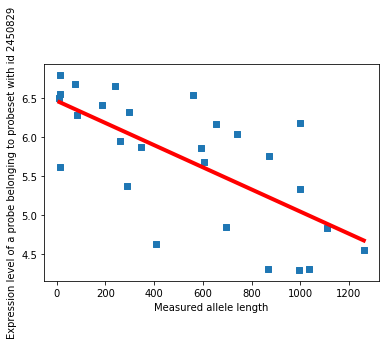

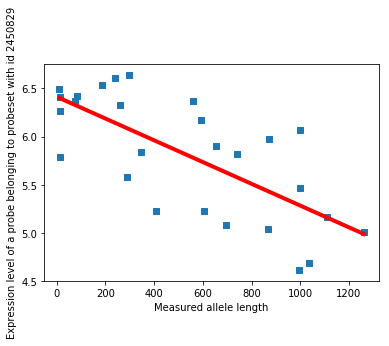

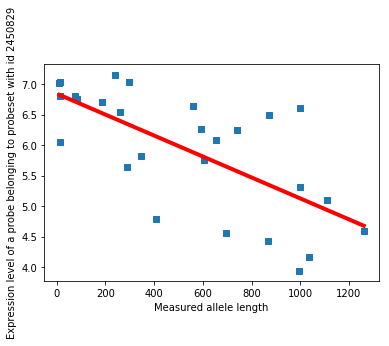

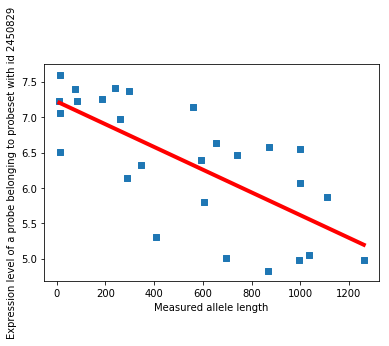

In [11]:
expression_per_probeset("2450829", ["TNNI1"], "analysis/experiment_muscle", muscle_metadata)